# Wersja skrócona dla nieprzepadających za czytaniem i/lub mających z tym jakiś problem :-)

1. Wrzuć notebook na Google Colab
2. Bardziej niecierpliwi wybierają opcję "Środowisko wykonawcze", potem "Zmień typ środowiska...", potem "Akceleracja" i z listy "GPU", wyluzowani nie robią nic
3. Uruchom notebook w całości - "Uruchom wszystko" (Ctrl+F9)
4. Czekaj, czekaj, ..., już za chwileczkę, już za momencik ...
5. Obejrzyj wyświetlone obrazki i oceń poprawność rozpoznania (wpisz wyniki do notebooka)
6. Zapisz notebook, ale tym razem BEZ CZYSZCZENIA PÓL OUTPUT z całą zawartością wygenerowaną w trakcie pracy!!!
7. Wrzuć notebook na platformę UPEL (obowiązkowo) i zapomnij o temacie (opcjonalnie)

# Klasyfikacja znaków drogowych z wykorzystaniem DCNN

Uwaga. Ćwiczenie powstało w oparciu o następujący [tutorial](https://www.pyimagesearch.com/2019/11/04/traffic-sign-classification-with-keras-and-deep-learning/).
Osoby zainteresowane tematem - moim zdaniem (Tomasz Kryjak) powinien to być każdy z Państwa -- zachęcam do prześledzenia tego dokumentu bardziej szczegółowo.

Inne podobne tutoriale:
- https://chsasank.github.io/keras-tutorial.html
- https://towardsdatascience.com/building-a-road-sign-classifier-in-keras-764df99fdd6a


To krótkie ćwicznie nie zastąpi pełnego kursu z AI, ale powinno pozwolić poznać podstawowe etapy związane z inżynierskim wykorzystaniem głębokich konwolucyjnych sieci neuronowych (DCNN - Deep Convolutional Neural Network).

## Założenia (v 1.0)

Poniższy notatnik jest kompletny i "do uruchomienia".
Jedyne wyzwania (niekoniecznie trywialne) to sprawy techniczne.
W przyszłości będzie to ulegało zmianom.

Uwaga. Czas obliczeń może być znaczny, ale można go wykorzystać np. na czytanie wskazanego tutoriala, tudzież analizę kodu :).

## Instalacja, sprawy techniczne

Notatnik do działania potrzebuje pakietów:
- OpenCV
- NumPy
- scikit-learn
- scikit-image
- imutils
- matplotlib
- TensorFlow 2.0 (CPU or GPU)

Opcje uruchomienia są dwie:
- Google Colaboratory - tam wszystko jest zainstalowane + mamy zasoby obliczeniowe, ale trzeba nieco pokombinować z dostarczeniem danych. Opis poniżej. Jest to też opcja rekomendowana.
- lokalnie (instalacja pakietów via *pip* lub poprzez PyCharm).

Dodatkowo należy pobrać bazę danych [GTSRB](https://drive.google.com/file/d/1EQ-tyVHIdVaa4_1bob1zv8zgaVmvyyqV/view?usp=sharing) (German Traffic Sign Recognition Benchmark) (300 MB).
Baza zawiera ponad 50000 obrazków dal 43 klas znaków.
Ma też dwie istotne wady:
- różna liczba przykładów z poszczególnych klas (od 180 do ponad 2000),
- część znaków stanowi duże wyzwanie (słaba jakość, kontrast) - uczciwie mówiąc, to niektóre trudno rozpoznać.

Nie wchodząc w zbytnie szczegóły.
Sieć DCNN "się uczy" (jest uczona) na podstawie przykładów.
Podobnie jak uczymy się my.
I teraz np. jeśli rozwiążemy 10 zadań nt. całek i 100 na temat pochodnych, to co na egzaminie wyjdzie lepiej ?
Stąd tego typu dysproporcja stanowi problem.
Słaba jakość zdjęć też utrudnia uczenie.


W przypadku przetwarzania lokalnego bazę należy rozpakować.


## Informacje wstępne DCNN

Co to jest sieć DCNN (Deep Convolutional Neural Network) ?

Model naśladujący działanie ludzkiego mózgu (tu konkretnie sposobu przetwarzania informacji wizyjnej).
Przedstawienie całej teorii w notatniku nie jest specjalnie wygodne -- zainteresowane osoby odsyłam do obszernej literatury.
Bez wchodzenia w szczegóły, sieć można traktować jako czarną skrzynkę, która na wejściu dostaje obraz, a na wyjściu wyniki (klasy obiektów).

Przy czym sieć trzeba nauczyć.
W uproszczeniu proces polega na tym, że prezentujemy sieci obraz, otrzymujemy jakiś wynik, porównujemy go z pożądanym i wg. specjalnego algorytmu modyfikujemy parametry sieci (tzw. wsteczna propagacja błędu).
Uwaga. To jest tzw. uczenie nadzorowane (z nauczycielem).
Istnieje tez uczenie bez nauczyciela (sieci samouczące) oraz ze wspomaganiem (reinforcement learning).
Szczególnie to drugie jest bardzo ciekawe - warto sobie o tym poczytać.
To ta metodologia stoi za sukcesami AlphaGo (w grze Go), czy w Starcrafta.

Mając nauczoną sieć, można przeprowadzić tzw. wnioskowanie (ang. *inference*).

Warto też wiedzieć, że sieci konwolucyjne to jest jedna z możliwości, dedykowana głównie do obrazów.
Dla innych zagadnienień stosowane są inne modele.
Ponadto w ramach samych DCNN występuje wiele różnych rozwiązań, choć są one zbudowane z mniej więcej podobnych "klocków".

Źródła dodatkowych informacji:
- https://en.wikipedia.org/wiki/Convolutional_neural_network
- https://d2l.ai/
- kursy na platformie Coursera
- i wiele innych źródeł.


## Co dzisiaj zrobimy ?

Przejdziemy przez następujące kroki:
- utworzenie modelu (definicja architektury sieci),
- implementacja funkcji do przygotowania zbioru uczącego,
- przygotowanie danych,
- uczenie,
- analiza wyników uczenia,
- testy: wnioskowanie.

Bardziej szczegółowe komentarze w tekście.

UWAGA: Osoby pracujące w Google Colab mogą przyspieszyć wykonywanie kodu przez zmianę środowiska wykonawczego na GPU. W tym celu wybierz 'Środowisko wykonawcze' -> 'Zmień typ środowiska wykonawczego'. Zaleca się również uruchomienie całego kodu (Ctrl+F9) przed przystąpieniem do analizy kolejnych fragmentów.


In [1]:
# Definicja architektury sieci

# Potrzebne biblioteki

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import matplotlib
matplotlib.use("Agg")

from sklearn.metrics import classification_report

from skimage import transform
from skimage import exposure
from skimage import io

from imutils import paths
import imutils

import matplotlib.pyplot as plt
import numpy as np

import argparse
import random
import os
import glob
import pickle
import time

import cv2


start_time = time.time()

# Siec do klasyfikacji
# Składa się z:
# 5 warstw konwolucyjnych - Conv2D, po nich funkcja aktywacji (relu), normalizacja oraz podpróbkowanie (zmiana rozdzielczości).
# 2 warstwy tzw. w pełni połączonych

# Uwaga. Sieć ta jest zbliżona do rozwiązana AlexNet (https://en.wikipedia.org/wiki/AlexNet).
# Natomiast sam AlexNet to jedna z pierwszych (a na pewno najbardziej znanych) sieci konwolucyjnych.
# To m.in. efekt sukcesu tego rozwiązania w konkursie  ImageNet Large Scale Visual Recognition Challenge.
# Artykuł ją opisujący ma ponad 70000 cytowań.

class TrafficSignNet:
  @staticmethod
  def build(width, height, depth, classes):

    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # CONV => RELU => BN => POOL
    model.add(Conv2D(8, (5, 5), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # second set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Klasyfikator softmax
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    #
    return model

print("[INFO] Model created")

[INFO] Model created


In [2]:
# Funkcja do przygotowania obrazów

def load_split(basePath, csvPath):
    # Inicjalizacja list dla danych i etykiet (klas znaków)
    data = []
    labels = []
  # Wczytanie zawartości pliku CVS z opisem danych, pominięcie pierwszej linii.
    rows = open(csvPath).read().strip().split("\n")[1:]
    # Wymieszanie przykładów uczących
    random.shuffle(rows)

    # Pętla po przykładach uczących
    for (i, row) in enumerate(rows):
      # Wypisanie informacji co 1000 przykładów
        if i > 0 and i % 1000 == 0:
           print("[INFO] processed {} total images".format(i))

        # Dla danego rzędu pozyskujemy etykietę (label) oraz ścieżkę do pliku
        (label, imagePath) = row.strip().split(",")[-2:]
      # "Skompletowanie" ścieżki i wczytanie obrazu
        imagePath = os.path.sep.join([basePath, imagePath])
        image = io.imread(imagePath)
        # Przeskalowanie do rozmiaru 32x32 i poprawa kontrastu metodą CLHAE (Contrast Limited Adaptive Histogram Equalization)
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)
        # Dodanie obrazka i etykiekt do listy
        data.append(image)
        labels.append(int(label))

    # Konwersja danych i etykiet na tablice NumPy
    data = np.array(data)
    labels = np.array(labels)
    # Zwracamy dane i etykiety (w formie krotki)
    return (data, labels)

print("[INFO] Function defined")

[INFO] Function defined


In [3]:
# Pobranie pliku z nazwami znakow
if not os.path.exists("signnames.csv") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/14_TSR_DCNN/signnames.csv --no-check-certificate

# Przygotowanie danych

# Jeśli ktoś używa Google Colab wszystko dzieje się automatycznie

if not os.path.exists("gtsrb.zip") :
  !gdown https://drive.google.com/uc?id=1EQ-tyVHIdVaa4_1bob1zv8zgaVmvyyqV

# 3. Zainstalować zip i rozpakować plik
# Uwaga ustawić scieżke
!apt install unzip
!unzip 'gtsrb.zip'


# Jeśli ktoś pracuje lokalnie, to trzeba tu ustawić ścieżkę.
# Ścieżka do danych
dataset = "gtsrb/"

# Wczytanie nazw etykiet
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[0] for l in labelNames]

# Ustawienie ścieżki do zbioru uczącego i testowego
trainPath = os.path.sep.join([dataset, "Train.csv"])
testPath = os.path.sep.join([dataset, "Test.csv"])

# Wczytanie danych uczących i testowych (dość długo trwa).
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split(dataset, trainPath)
(testX, testY) = load_split(dataset, testPath)

# Przeskalowanie danych do zakresu [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# Zakodowanie etykiet danych uczących i testowych w formacie *one-hot* (z całego wektora tylko jedna wartość to 1, reszta 0).
# To wprost koresponduje z wyjściem z sieci (warstwa softmax), gdzie otrzymujemy wektor w długości takiej, ile mamy klas (tu 43) i wyszukujemy w nim maksimum.
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

# Zapis danych uczących i testowych do pliku (żeby tego ew. nie powtarzać), jak coś na dalszym etapie pójdzie nie tak.
with open('train_test.pickle', 'wb') as f:
    pickle.dump([trainX, trainY, testX, testY], f)

print("[INFO] saving training and testing data...")

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: gtsrb/train/27/00027_00003_00013.png  
  inflating: gtsrb/train/27/00027_00003_00014.png  
  inflating: gtsrb/train/27/00027_00003_00015.png  
  inflating: gtsrb/train/27/00027_00003_00016.png  
  inflating: gtsrb/train/27/00027_00003_00017.png  
  inflating: gtsrb/train/27/00027_00003_00018.png  
  inflating: gtsrb/train/27/00027_00003_00019.png  
  inflating: gtsrb/train/27/00027_00003_00020.png  
  inflating: gtsrb/train/27/00027_00003_00021.png  
  inflating: gtsrb/train/27/00027_00003_00022.png  
  inflating: gtsrb/train/27/00027_00003_00023.png  
  inflating: gtsrb/train/27/00027_00003_00024.png  
  inflating: gtsrb/train/27/00027_00003_00025.png  
  inflating: gtsrb/train/27/00027_00003_00026.png  
  inflating: gtsrb/train/27/00027_00003_00027.png  
  inflating: gtsrb/train/27/00027_00003_00028.png  
  inflating: gtsrb/train/27/00027_00003_00029.png  
  inflating: gtsrb/train/27/00027_00004_00000.png  

In [4]:
# Przygotowanie do uczenia modelu

# Liczba etykiet
numLabels = trainY.shape[1]

# Liczba epok (iteracji algorytmu uczenia)
NUM_EPOCHS = 15

# Współczynnik uczenia
INIT_LR = 1e-3

# Rozmiar "wsadu" do batch normalization (https://en.wikipedia.org/wiki/Batch_normalization)
BS = 64

# Wczytanie zbioru uczącego i testowego
with open('train_test.pickle', 'rb') as f:
    trainX, trainY, testX, testY = pickle.load(f)

# Stworzenie obiektu do augumentacji danych
# Co to jest augumentacja ?
# Ogólnie jest to "sztuczne" zwiększenie liczebności zbioru uczącego.
# Jak można się domyśleć po nazwach, tu obejmuje takie operacje jak: obrót, skalowanie, przesunięcie, czy zniekształcenie.
aug = ImageDataGenerator(
  rotation_range=10,
  zoom_range=0.15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.15,
  horizontal_flip=False,
  vertical_flip=False,
  fill_mode="nearest")

# Inicjalizacja optymalizatora oraz kompilacja modułu
# Parameter LR (Learning Rate) mówi nam o tym, jak bardzo sieć się uczy (jak bardzo możemy zmienić paramtery z danym kroku).
# Proszę zwrócić uwagę, że ustawia się również jego zanikanie (decay).
# Upraszczając (znowu). W poszukiwaniu optimum lokalnego, w przestrzeni rozwiązań (bo do tego ostatecznie sprowadza się problem uczenia), na początu dopuszczamy duże przesunięcia, a z czasem coraz mniejsze.

print("[INFO] compiling model...")
# opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=3,
  classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
  metrics=["accuracy"])

# Wyliczanie wag dla klas -> wskazanie dla modułu, że występuje problem z różną liczebnością zbioru uczącego.
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals
classWeightD = {x: classWeight[x] for x in range(0,classWeight.shape[0]) }

print("[INFO] model ready to learn...")

[INFO] compiling model...
[INFO] model ready to learn...


In [5]:
# Uczenie modelu
# To może chwile trwać - ograniczyliśmy liczbę epok (iteracji procesu do 15).
# Ogólnie jest to etap, który dobrze można akcelerować na GPU.
# Przy czym lokalna konfiguracja TensorFlow/Keras do współpracy z GPU nie jest prosta (i na pewno trwa znacznie dłużej niż to uczenie :)).
# W kolejnych epokach wyświetlają się wskaźniki
# - accuracy - dokładność na zbiorze uczącym (ma rosnąć)
# - loss - funkcja błędu dla zbioru uczącego (ma maleć)
# - val_accuracy - dokładność dla zbioru walidacyjnego (ma rosnąć)
# - val_loss - funkcja błędu  na zbiorze walidacyjnym (ma maleć)

# Zbiory uczące i testowe są rozłączne, aby móc zaobserwować zjawisko "przeuczenia" modelu (ang. overfitting).
# Najkrócej ujmując - jest to analogia nauki na pamięć. Model dobrze nauczy się danych uczących, a kiepsko będzie sobie radził na innych.



print("[INFO] training network...")
H = model.fit(
  aug.flow(trainX, trainY, batch_size=BS),
  validation_data=(testX, testY),
  steps_per_epoch=trainX.shape[0] // BS,
  epochs=NUM_EPOCHS,
  class_weight=classWeightD,
  verbose=1)

# Zapis sieci na dysk - żeby nie trzeba było drugi raz uczyć.
print("[INFO] serializing network to '{}'... trafficsignnet.model")
model.save("trafficsignnet.model")


print("[INFO] training network done")

[INFO] training network...
Epoch 1/15
612/612 [==============================] - 44s 46ms/step - loss: 8.1261 - accuracy: 0.1384 - val_loss: 3.8920 - val_accuracy: 0.0785
Epoch 2/15
612/612 [==============================] - 27s 45ms/step - loss: 4.7151 - accuracy: 0.3679 - val_loss: 1.3273 - val_accuracy: 0.5449
Epoch 3/15
612/612 [==============================] - 27s 45ms/step - loss: 3.3470 - accuracy: 0.5136 - val_loss: 1.0265 - val_accuracy: 0.6384
Epoch 4/15
612/612 [==============================] - 27s 44ms/step - loss: 2.4890 - accuracy: 0.6167 - val_loss: 0.7958 - val_accuracy: 0.7196
Epoch 5/15
612/612 [==============================] - 27s 44ms/step - loss: 1.9718 - accuracy: 0.6900 - val_loss: 0.7204 - val_accuracy: 0.7674
Epoch 6/15
612/612 [==============================] - 27s 44ms/step - loss: 1.5892 - accuracy: 0.7447 - val_loss: 0.6263 - val_accuracy: 0.7764
Epoch 7/15
612/612 [==============================] - 28s 46ms/step - loss: 1.3122 - accuracy: 0.7856 - val_l

[INFO] training network done


## Ewaluacja

Dla danego znaku i wyniku klasyfikacji mamy 4 możliwości:
- TP (True Positive) - wynik klasyfikacji i stan faktyczny są zgodne,
- FP (False Positive) - klasyfikacja wskazuje na znak X, ale stan faktyczny to znak Y,
- FN (False Negative) - klasyfikacja wskazuje, że to nie znak X, a stan faktyczny to X,
- TN (True Negative) - klasyfikacja wskazuje, że to nie znak X i to nie jest znak X.

Na tej podstawie można konstruować wskaźniki:
- precision = TP / (TP+FP)
- recall = TP / (TP+FN)
- f1 = 2 * precision*recall / (precision+recall)

Szerszy opis na [Wikipedii](https://en.wikipedia.org/wiki/Sensitivity_and_specificity).

Parametr *support* oznacza liczbę próbek.

Warto na chwilę się zastanowić nad tym, co oznaczają wskaźniki.
Precyzja (precision) będzie tym większa, im mniej będzie FP, czyli sytuacji, że znak Y będzie uznany X (należący do ewaluowanej klasy).
Natomiast  (recall), będzie tym większa, im mniej będzie FN, czyli sytuacji, że znak X (należący na rozpatrywanej klasy) będzie uznany co Y.

Należy zwrócić uwagę, że:
- w idealnym przypadku (brak błędów) oba powinny być 1,
- są poniekąd przeciwstawne - wszystko zależy od tego, czy nasz klasyfikator jest mniej, czy bardziej restrykcyjny.
- f1, jakaś średnia harmoniczna, łączy oba wskaźniki.


Proszę jeszcze zwrócić uwagę na rysunek `train.png` - wyświetlić i zastanowić się co oznacza.




[INFO] evaluating network...
198/198 [==============================] - 1s 3ms/step
                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.49      1.00      0.66        60
         Speed limit (30km/h)       0.96      0.89      0.92       720
         Speed limit (50km/h)       0.97      0.89      0.93       750
         Speed limit (60km/h)       0.87      0.88      0.88       450
         Speed limit (70km/h)       0.97      0.94      0.95       660
         Speed limit (80km/h)       0.77      0.91      0.84       630
  End of speed limit (80km/h)       0.98      0.87      0.92       150
        Speed limit (100km/h)       0.95      0.74      0.83       450
        Speed limit (120km/h)       0.87      0.96      0.91       450
                   No passing       0.98      0.98      0.98       480
 No passing veh over 3.5 tons       0.99      0.96      0.97       660
 Right-of-way at intersection       0.87      0.96      0.91   

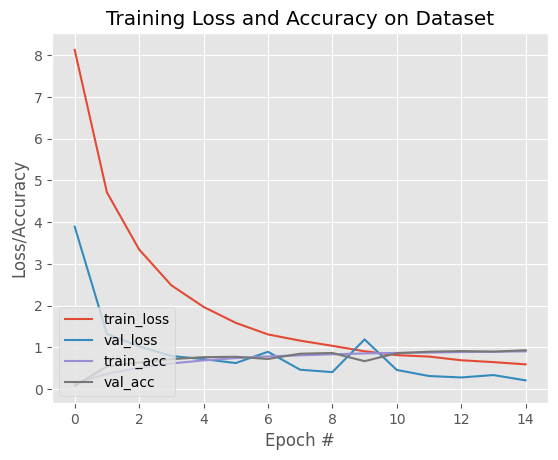

In [6]:
# Ewaluacja modelu (sprawdzenie jak się nauczył)
%matplotlib inline

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
  predictions.argmax(axis=1), target_names=labelNames))

# Wykres funkcji kosztu i dokładności
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("train.png")



## Wnioskowanie

Jak już mamy nauczony model, to możemy go użyć do wnioskowania (ang. inference).
Wtedy na wejście podajemy zdjęcie znaku, a na wyjściu uzyskujemy informację co to za znak.


In [7]:
# Wczytujemy model
print("[INFO] loading model...")
model = load_model("trafficsignnet.model")
# Wczytujemy nazwy klas (ponownie)
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[0] for l in labelNames]
# Wczytujemy obrazy, mieszamy, wybieramy podzbiór:
print("[INFO] predicting...")
imagePaths = list(paths.list_images("gtsrb/Test"))
random.shuffle(imagePaths)
imagePaths = imagePaths[:25]

if not os.path.exists('examples'):
  os.mkdir('examples')

# Pętla po obrazach
for (i, imagePath) in enumerate(imagePaths):
  # Wczytujemy obraz, skalujemy, wyrównujemy histogram - dokładnie jak wcześniej

  image = io.imread(imagePath)
  image = transform.resize(image, (32, 32))
  image = exposure.equalize_adapthist(image, clip_limit=0.1)
  # Skalujemy do wartości 0,1
  image = image.astype("float32") / 255.0
  image = np.expand_dims(image, axis=0)

  # Przeprowadzamy wnioskowanie
  preds = model.predict(image)
  # Wybieramy największą odpowedź
  j = preds.argmax(axis=1)[0]
  label = labelNames[j]

  # Wizualizacja i zapis do pliku
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=128)
  cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX,
    0.45, (0, 0, 255), 2)
  p = os.path.sep.join(["examples", "{}.png".format(i)])
  cv2.imwrite(p, image)

print("[INFO] done...")

print("--- %s seconds ---" % (time.time() - start_time))

[INFO] loading model...
[INFO] predicting...
1/1 [==============================] - 0s 31ms/step
[INFO] done...
--- 937.7935910224915 seconds ---


## Ocena wyników

Na samym końcu patrzymy co nam wyszło.
Z uwagi na ograniczoną liczbę epok uczenia "szału nie ma", ale i tak znaki o lepszej jakości powinny być rozpoznane poprawnie - proszę w notebooku umieścić informację o liczbie prawidłowo rozpoznanych znaków (w formie komentarza w kodzie lub dodatkowego pola tekstowego "Markdown") - należy obejrzeć wyświetlone obrazy z katalogu `examples` i zweryfikować zgodność obrazu z opisem (np. w formie: x/25 poprawnie, y/25 źle, z/25 trudno ocenić, bo nic nie widać).


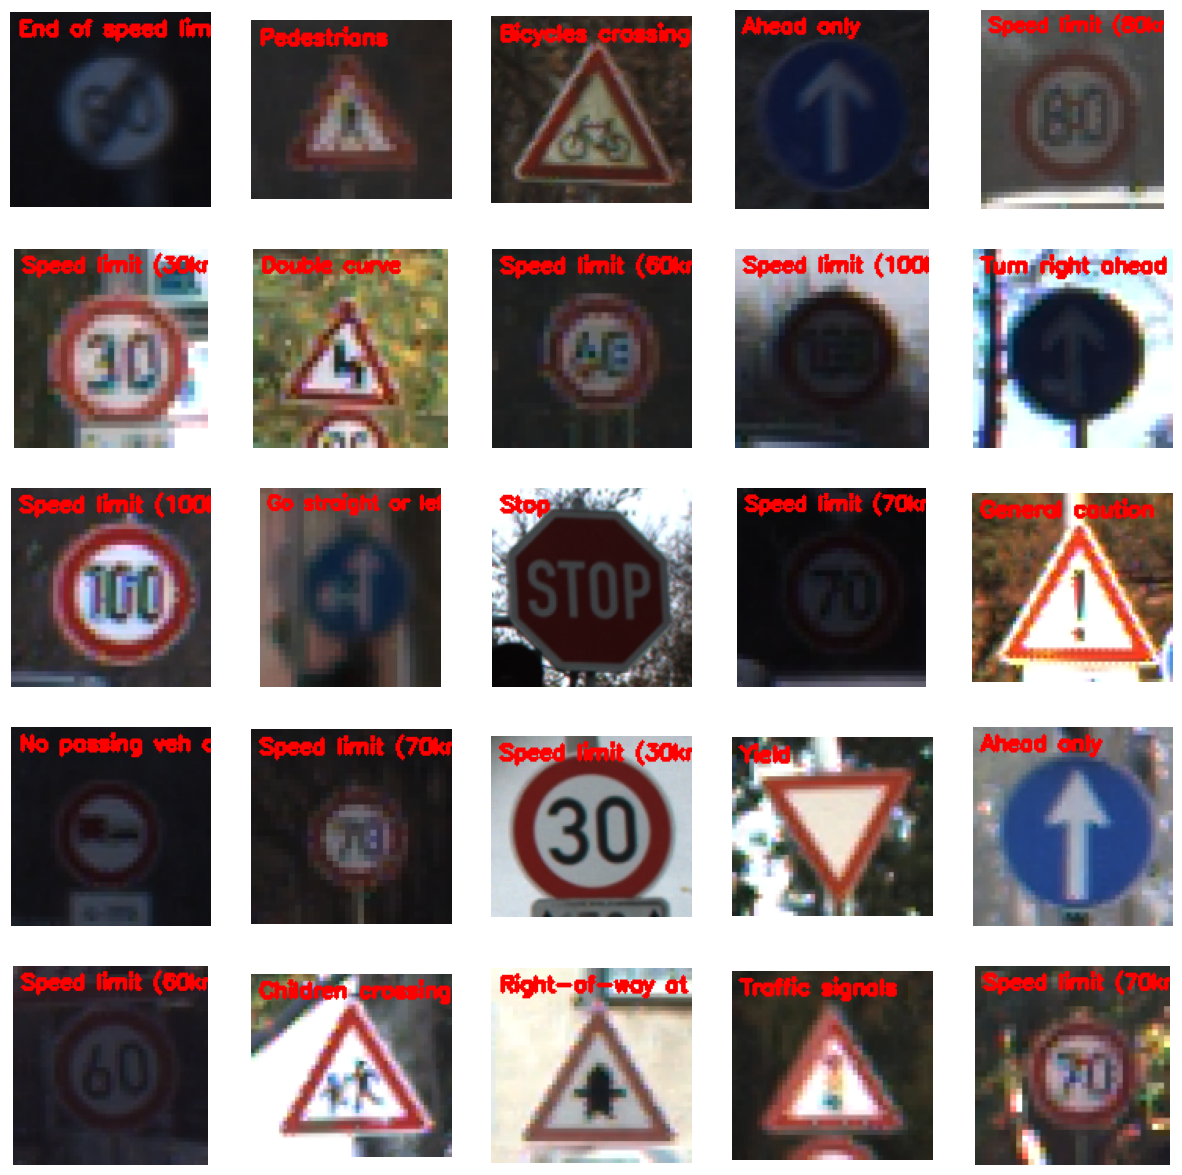

In [8]:
path="examples/*.png"
images = []
for image in glob.glob(path):
    img = cv2.imread( image, cv2.IMREAD_COLOR)
    img = cv2.cvtColor( img, cv2.COLOR_BGR2RGB)
    images.append( img )

fig=plt.figure(figsize=(15,15))
for i in range(len(images)):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

## Uzyskane wyniki końcowe

Poprawnie:      24

Niepoprawnie:   1 (10/25)

Nie wiadomo:    0
